In [140]:
from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import skfda
from scipy import ndimage as ndi
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)

pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [4]:
trimmed_regions = {
    "pm3": [0.07, 0.28],
    "pm4": [0.33, 0.45],
    "pm5": [0.53, 0.70],
    "pm6": [0.80, 0.86],
    "pm7": [0.88, 0.96],
}
untrimmed_regions = {
    "pm3": [0.12, 0.30],
    "pm4": [0.35, 0.44],
    "pm5": [0.52, 0.65],
    "pm6": [0.73, 0.78],
    "pm7": [0.79, 0.85],
}

In [21]:
prof_raw = da.load_all_cached_profile_data(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/'), '**/*single_unreg/*.nc')
prof_reg = da.load_all_cached_profile_data(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/'), '**/*matlab_reg/*-trimmed*.nc')

In [23]:
err_prof_raw, err_tbl_raw = da.get_resid_rr(
    prof_raw, 
    summarize=True, 
    regions=trimmed_regions,
    value_name='error', 
    rescale=True
)
err_prof_reg, err_tbl_reg = da.get_resid_rr(
    prof_reg, 
    summarize=True, 
    regions=trimmed_regions,
    value_name='error', 
    rescale=True
)

err_tbl_raw['reg_strategy'] = 'raw'
err_tbl_reg['reg_strategy'] = 'reg'
err_tbl_raw.head(3)

,error,region,animal,reg_strategy
0,0.010622,pm3,0,raw
1,0.018455,pm3,1,raw
2,0.013500,pm3,2,raw


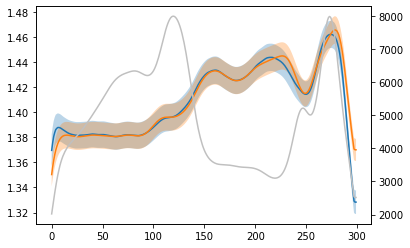

In [55]:
ax = plots.plot_profile_avg_with_bounds(prof_raw.sel(wavelength='r', pair=0), label='raw')
plots.plot_profile_avg_with_bounds(prof_reg.sel(wavelength='r', pair=0), ax=ax, label='reg')
plt.twinx();
plt.plot(prof_raw.sel(wavelength='470').mean(dim='pair').mean(dim='strain').T, color='silver');
# plt.legend();

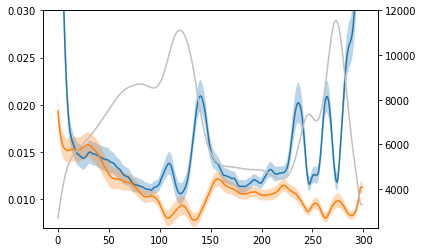

In [54]:
ax = plots.plot_profile_avg_with_bounds(err_prof_raw)
plots.plot_profile_avg_with_bounds(err_prof_reg, ax=ax)
ax.set_ylim(0.007,0.03)
plt.twinx();
plt.plot(prof_raw.sel(wavelength='410').mean(dim='pair').mean(dim='strain').T, color='silver');

In [71]:
warps = []
for warp_path in sorted(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/').glob('**/*_matlab*/*.npy')):
    with open(warp_path, 'rb') as f:
        warps.append(np.load(f))

# animal, pair, position
warps = np.moveaxis(np.concatenate(warps, axis=-1), -1, 0)

In [75]:
warps.shape

(863, 2, 200)

In [126]:
iden = np.moveaxis(
    np.tile(np.linspace(1,100,warps.shape[-1]), (2, warps.shape[0], 1)),
    1, 0
)

In [137]:
warp_mag = np.abs(iden - warps)

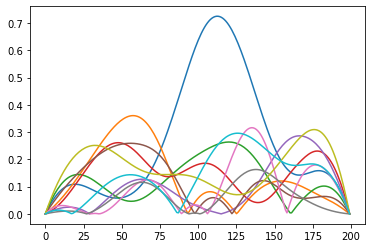

In [148]:
plt.plot(warp_mag[:10, 0, :].T);

In [149]:
df = []
for i in range(warp_mag.shape[1]):
    df_ = profile_processing.summarize_over_regions(
        warp_mag[:,i],
        regions=untrimmed_regions,
        value_name="warp_magnitude",
        rescale=True
    )
    df_['pair'] = i
    df.append(df_)
df = pd.concat(df)
df.head(3)

,warp_magnitude,region,animal,pair
0,0.074427,pm3,0,0
1,0.283304,pm3,1,0
2,0.087068,pm3,2,0


In [171]:
all_df_raw = df.merge(err_tbl_raw, on=['animal', 'region'])
all_df_reg = df.merge(err_tbl_reg, on=['animal', 'region'])
all_df_reg['reg_strategy'] = 'reg'

all_df = pd.concat([all_df_raw, all_df_reg])

In [181]:
all_df.to_csv('/Users/sean/code/pharynx_redox/data/figures/err_by_warp_and_strategy.csv')

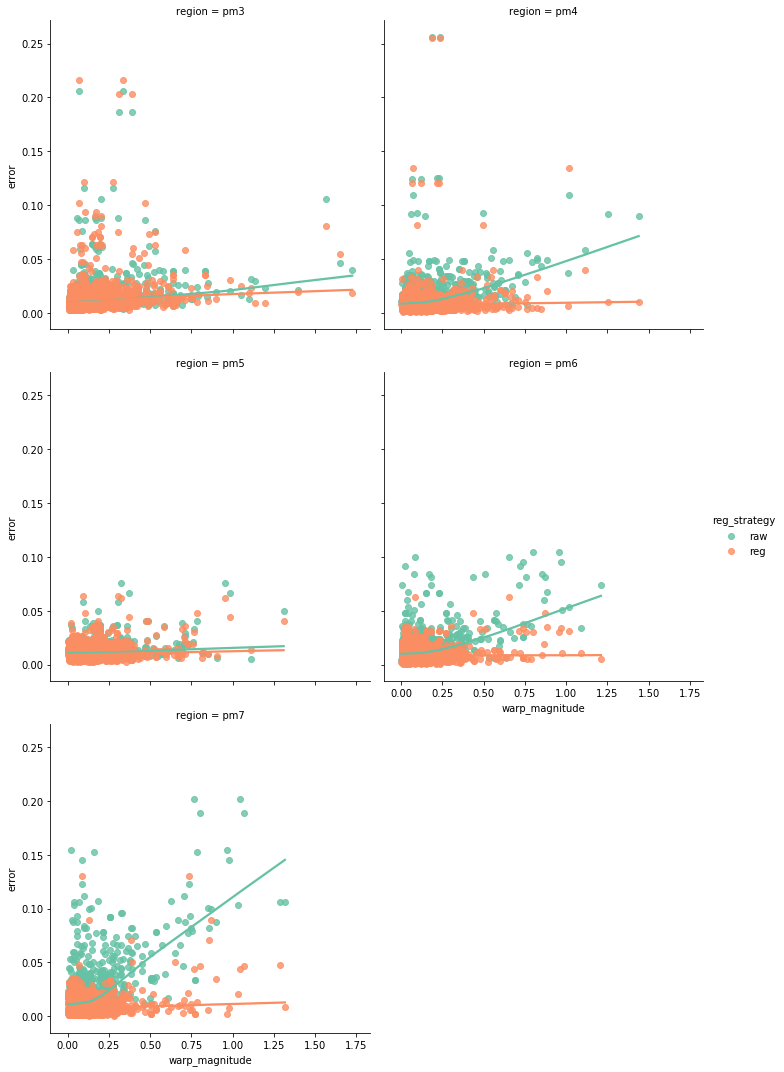

In [184]:
sns.lmplot(
    x='warp_magnitude',
    y='error',
    col='region',
    col_wrap=2,
    hue='reg_strategy',
    data=all_df,
    palette='Set2',
    lowess=True
)
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/err_by_warp_and_strategy.pdf')